## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install dependencies
# !pip install fastai jupyter timm torchtnt

# # Install PyTorch with CUDA
# !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install utility packages
# !pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
import json
import math
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file, get_source_code
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomTrivialAugmentWide

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF
from torchtnt.utils import get_module_summary

# Import fastai computer vision functionality 
from fastai.vision.all import *

## Setting Up the Project

### Setting a Random Number Seed

In [3]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [4]:
device = default_device()
dtype = torch.float32
device, dtype

(device(type='cuda', index=0), torch.float32)

### Setting the Directory Paths

In [5]:
# The name for the project
project_name = f"fastai-timm-image-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir, 
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

## Loading and Exploring the Dataset

### Setting the Dataset Path

In [6]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k-zip'

zip_file_name = dataset_name[:-4]

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{zip_file_name}')

pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

### Downloading the Dataset

In [7]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{zip_file_name}.zip"

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
untar_data(dataset_url, archive=archive_dir.absolute(), data=dataset_dir.absolute())

# Delete the archive if specified
if archive_path.exists() and delete_archive: archive_path.unlink()

### Inspecting the Class Distribution

#### Get Dataset Information

In [8]:
# Get the file paths for each image in the dataset
img_paths = get_image_files(dataset_path)

# Get the number of samples for each image class
class_counts = Counter(path.parent.name for path in img_paths)

# Get the class names
class_names = list(class_counts.keys())

# Print the number of samples for each image class
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
class_counts_df

Count
call              6939
dislike           7028
fist              6882
four              7183
like              6823
mute              7139
no_gesture       27823
ok                6924
one               7062
palm              7050
peace             6965
peace_inverted    6876
rock              6883
stop              6893
stop_inverted     7142
three             6940
three2            6870
two_up            7346
two_up_inverted   6967

#### Visualize the class distribution

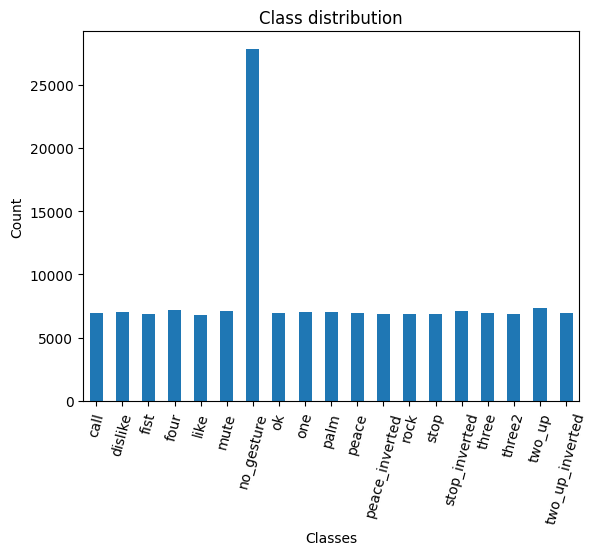

In [9]:
# Plot the distribution
class_counts_df.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts_df.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.gca().legend().set_visible(False)
plt.show()

### Visualizing Sample Images

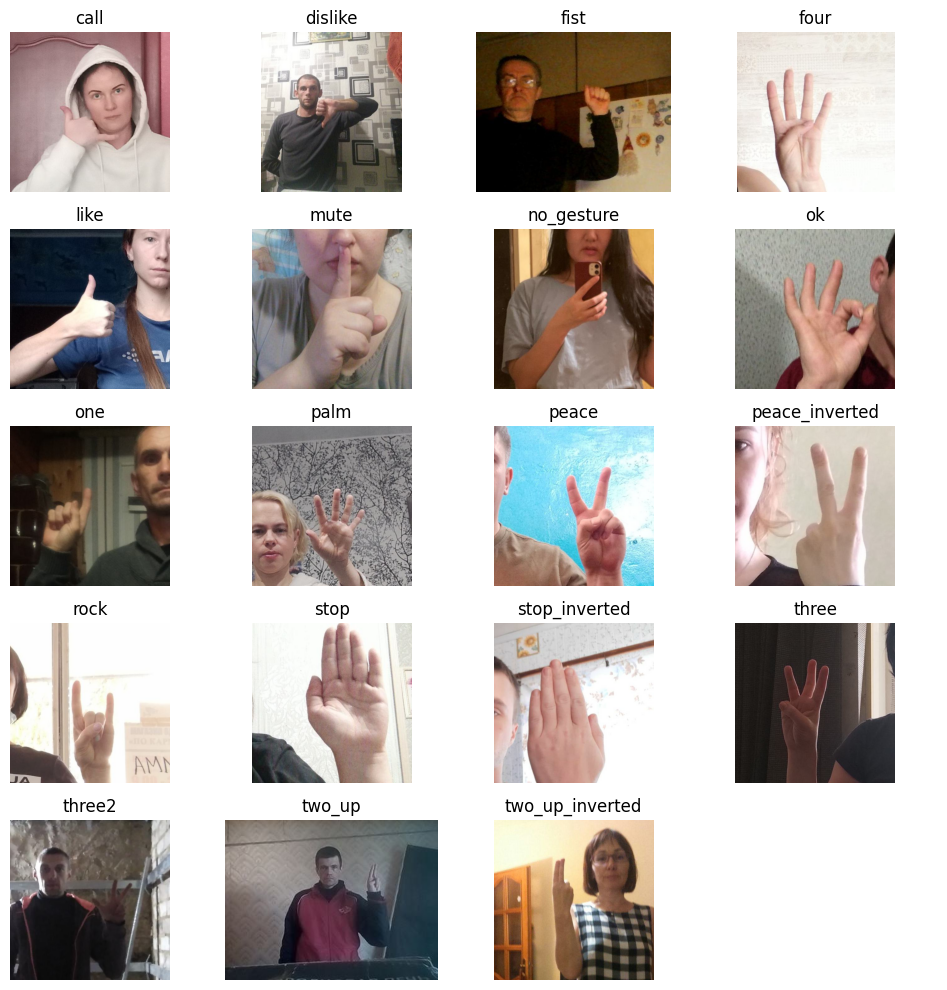

In [10]:
# Get paths for the first sample in the dataset for each class
sample_paths = [next((dataset_path/class_name).iterdir()) for class_name in class_names]
sample_paths.sort()

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_paths) else 0)
n_cols = grid_size

# Create a list to store the first image found for each class
images = [Image.open(path) for path in sample_paths]
labels = [path.parent.name for path in sample_paths]

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(images) and images[i]:
        # Add the image to the subplot
        ax.imshow(np.array(images[i]))
        # Set the title to the corresponding class name
        ax.set_title(labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [11]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

0
0                  resnet18.a1_in1k
1                  resnet18.a2_in1k
2                  resnet18.a3_in1k
3  resnet18.fb_ssl_yfcc100m_ft_in1k
4     resnet18.fb_swsl_ig1b_ft_in1k
5               resnet18.gluon_in1k
6                  resnet18.tv_in1k
7                resnet18d.ra2_in1k

### Inspecting the ResNet18-D Model Configuration

In [12]:
# Import the resnet module
from timm.models import resnet

# Define the ResNet model variant to use
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model
model_cfg = resnet.default_cfgs[resnet_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

0
url               https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
hf_hub_id                                                                                                               timm/
custom_load                                                                                                             False
input_size                                                                                                      (3, 224, 224)
test_input_size                                                                                                 (3, 288, 288)
fixed_input_size                                                                                                        False
interpolation                                                                                                         bicubic
crop_pct                                                                                                                0.875
test_crop_pct                                                                                                            0.95
crop_mode                                                                                                              center
mean                                                                                                    (0.485, 0.456, 0.406)
std                                                                                                     (0.229, 0.224, 0.225)
num_classes                                                                                                              1000
pool_size                                                                                                              (7, 7)
first_conv                                                                                                            conv1.0
classifier                                                                                                                 fc
origin_url                                                                https://github.com/huggingface/pytorch-image-models

### Retrieving Normalization Statistics

In [13]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

0      1      2
0  0.485  0.456  0.406
1  0.229  0.224  0.225

### Loading the ResNet18-D Model

In [14]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
resnet18 = resnet18.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
resnet18.device = device
resnet18.name = resnet_model

### Selecting the Model

In [15]:
model = resnet18

### Summarizing the Model

In [16]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

/home/innom-dt/mambaforge/envs/fastai-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs  \
0   ResNet       11.2 M                 11.2 M       44.9 M         2.7 G   
2   Conv2d          864                    864        3.5 K        14.2 M   
5   Conv2d        9.2 K                  9.2 K       36.9 K         150 M   
8   Conv2d       18.4 K                 18.4 K       73.7 K         301 M   
14  Conv2d       36.9 K                 36.9 K        147 K         150 M   
19  Conv2d       36.9 K                 36.9 K        147 K         150 M   
23  Conv2d       36.9 K                 36.9 K        147 K         150 M   
28  Conv2d       36.9 K                 36.9 K        147 K         150 M   
33  Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
38  Conv2d        147 K                  147 K        589 K         150 M   
43  Conv2d        8.2 K                  8.2 K       32.8 K         8.4 M   
46  Conv2d        147 K                  147 K        589 K         150 M   
51  Conv2d        147 K                  147 K        589 K         150 M   
56  Conv2d        294 K                  294 K        1.2 M        75.5 M   
61  Conv2d        589 K                  589 K        2.4 M         150 M   
66  Conv2d       32.8 K                 32.8 K        131 K         8.4 M   
69  Conv2d        589 K                  589 K        2.4 M         150 M   
74  Conv2d        589 K                  589 K        2.4 M         150 M   
79  Conv2d        1.2 M                  1.2 M        4.7 M        75.5 M   
84  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   
89  Conv2d        131 K                  131 K        524 K         8.4 M   
92  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   
97  Conv2d        2.4 M                  2.4 M        9.4 M         150 M   

   Backward FLOPs            In size           Out size  
0           5.3 G   [1, 3, 256, 256]            [1, 19]  
2          14.2 M   [1, 3, 256, 256]  [1, 32, 128, 128]  
5           301 M  [1, 32, 128, 128]  [1, 32, 128, 128]  
8           603 M  [1, 32, 128, 128]  [1, 64, 128, 128]  
14          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
19          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
23          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
28          301 M    [1, 64, 64, 64]    [1, 64, 64, 64]  
33          150 M    [1, 64, 64, 64]   [1, 128, 32, 32]  
38          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
43         16.8 M    [1, 64, 32, 32]   [1, 128, 32, 32]  
46          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
51          301 M   [1, 128, 32, 32]   [1, 128, 32, 32]  
56          150 M   [1, 128, 32, 32]   [1, 256, 16, 16]  
61          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
66         16.8 M   [1, 128, 16, 16]   [1, 256, 16, 16]  
69          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
74          301 M   [1, 256, 16, 16]   [1, 256, 16, 16]  
79          150 M   [1, 256, 16, 16]     [1, 512, 8, 8]  
84          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]  
89         16.8 M     [1, 256, 8, 8]     [1, 512, 8, 8]  
92          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]  
97          301 M     [1, 512, 8, 8]     [1, 512, 8, 8]

## Preparing the Data

### Selecting a Sample Image

Image Label: stop


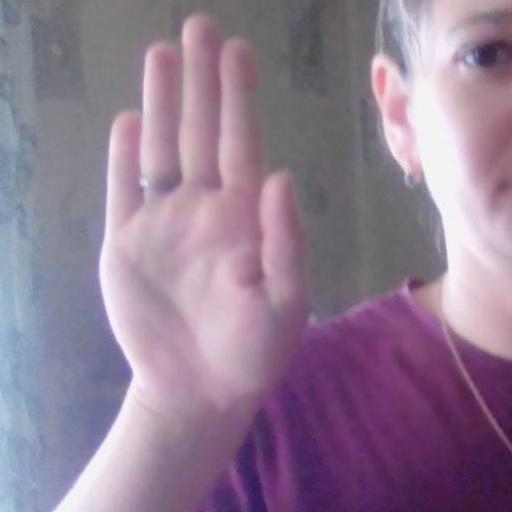

In [17]:
# Select a random item from the dataset
item_path = random.choice(img_paths)

label = item_path.parent.name
sample_img = Image.open(item_path)
    
print(f"Image Label: {label}")
    
# Display the image
sample_img

### Data Augmentation

In [18]:
# Define the number of potential values for each augmentation
num_bins = 31

# Define the types of potential augmentations and their possible values
custom_augmentation_space = {
    # Identity operation doesn't change the image
    "Identity": (torch.tensor(0.0), False),
            
    # Distort the image along the x or y axis, respectively.
    "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
    "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

    # Move the image along the x or y axis, respectively.
    "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
    "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

    # Rotate operation: rotates the image.
    "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

    # Adjust brightness, color, contrast,and sharpness respectively.
    "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
    "Color": (torch.linspace(0.0, 0.99, num_bins), True),
    "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
    "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

    # Reduce the number of bits used to express the color in each channel of the image.
    "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

    # Invert all pixel values above a threshold.
    "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

    # Maximize the image contrast by setting the darkest color to black and the lightest to white.
    "AutoContrast": (torch.tensor(0.0), False),

    # Equalize the image histogram to improve its contrast.
    "Equalize": (torch.tensor(0.0), False),
}

# Create a CustomTrivialAugmentWide the specified augmentation space
trivial_aug = CustomTrivialAugmentWide(fill=(123, 117, 104), op_meta=custom_augmentation_space)

#### Test the transform

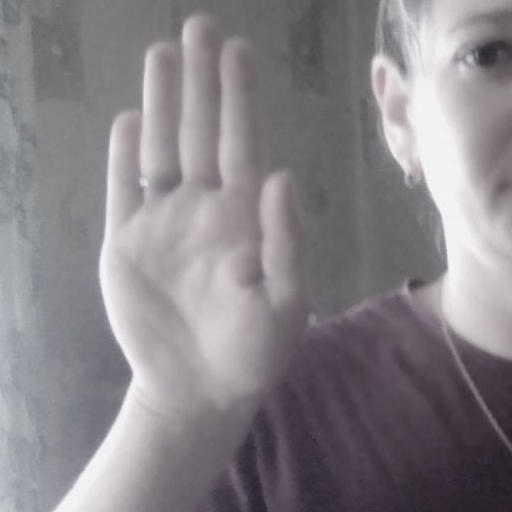

In [19]:
# Apply the TrivialAugmentWide to the tensor
trivial_aug(sample_img)

### Image Resizing and Padding

#### Set training image size

In [20]:
train_sz = 288

#### Test the transform

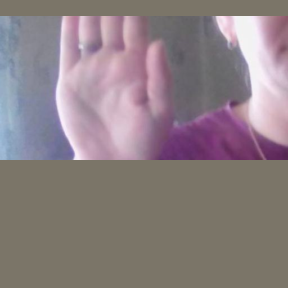

In [21]:
# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])

# Compose transforms to resize and pad input images
resize_pad = transforms.Compose([
    ResizeMax(max_sz=train_sz),                       # Create a `ResizeMax` object
    PadSquare(shift=True),                            # Create a `PadSquare` object
    transforms.Resize([train_sz] * 2, antialias=True) # Ensure the image is square
])

# Resize and pad the tensor
resized_padded_img = resize_pad(cropped_img)

# Display the updated image
display(resized_padded_img)

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Create a Fastai Transform Wrapper

In [22]:
%%writefile fastai_transforms.py
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from fastcore.transform import Transform
from fastai.vision.core import PILImage

class TorchvisionComposeWrapper(Transform):
    """
    Wrap Torchvision transforms for use within Fastai's pipeline.

    Args:
    - transforms_list (list): List of Torchvision transforms.
    """
    
    def __init__(self, transforms_list):
        """Initialize with a list of torchvision transforms."""
        self.transforms = transforms.Compose(transforms_list)

    def encodes(self, x: PILImage) -> PILImage:
        """Apply the Torchvision transformations to the PILImage."""
        return PILImage(self.transforms(x))

Overwriting fastai_transforms.py


### Item and Batch Transforms

In [23]:
from fastai_transforms import TorchvisionComposeWrapper

# Define the transformations to apply to individual images
img_tfms = [trivial_aug, resize_pad]
item_tfms = [TorchvisionComposeWrapper(img_tfms)]

# Convert normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1).to(device)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1).to(device)

# Define the transforms to apply to batches of tensors
batch_tfms = [Normalize(mean=mean_tensor, std=std_tensor)]

### Training Batch Size

In [24]:
bs = 32

### Initialize DataLoaders

In [25]:
dls = ImageDataLoaders.from_folder(
    path=dataset_path,    # The path to the root folder containing the images.
    valid_pct=0.1,        # The percentage of the images to use for validation
    bs=bs,                # The number of samples to process in a single pass through the model
    item_tfms=item_tfms,  # A list of transformations to apply to each individual image.
    batch_tfms=batch_tfms # A list of transformations to apply to each batch of tensors
)

# Remove the trivial augmentation transform
dls.valid.after_item = Pipeline([TorchvisionComposeWrapper(img_tfms[1:]), ToTensor])

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(dls.train),
    'Number of batches in validation DataLoader:': len(dls.valid)}
).to_frame().style.hide(axis='columns')

/home/innom-dt/mambaforge/envs/fastai-env/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


### Inspect Samples

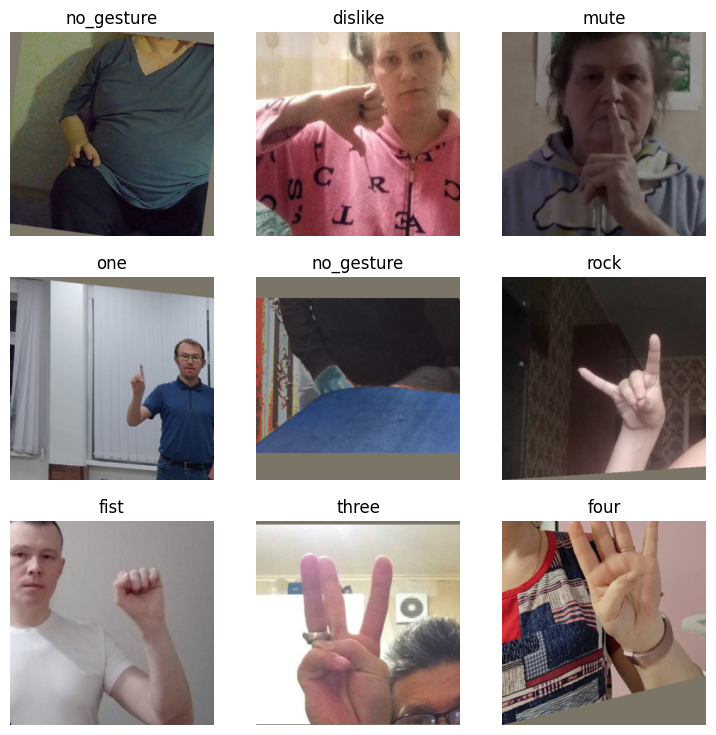

In [26]:
dls.train.show_batch()

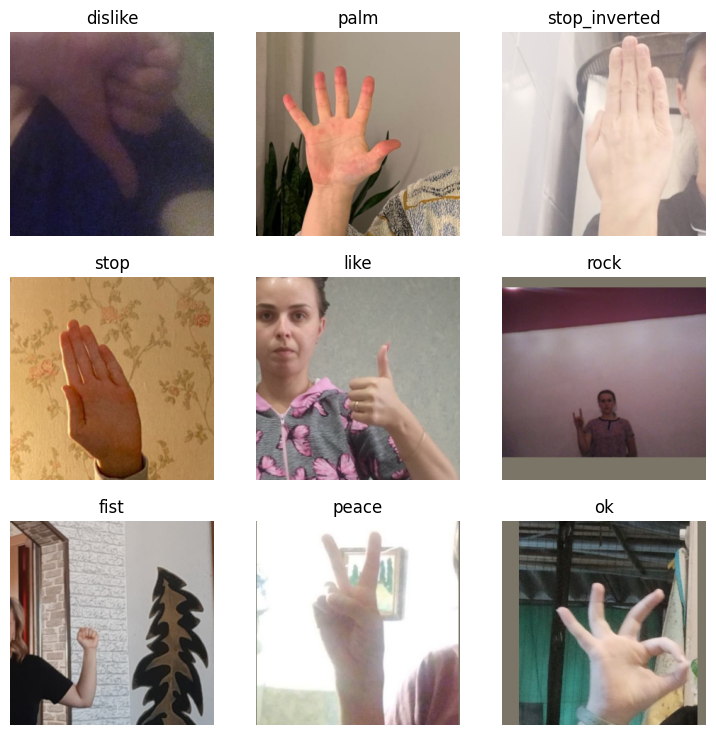

In [27]:
dls.valid.show_batch()

## Fine-tuning the Model

### Set the Model Checkpoint Path

In [28]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

fastai-timm-image-classifier/2023-10-06_16-25-49/resnet18d.pth


### Save the Normalization Stats

In [29]:
# Convert tuples to dictionaries for easier JSON representation
norm_stats_dict = {"mean": norm_stats[0], "std_dev": norm_stats[1]}

# Export to JSON
with open(f"{checkpoint_dir}/norm_stats.json", "w") as f:
    json.dump(norm_stats_dict, f)

# Print the name of the file that the normalization stats were written to
print(f"{checkpoint_dir}/norm_stats.json")

fastai-timm-image-classifier/2023-10-06_16-25-49/norm_stats.json


### Saving the Class Labels

In [30]:
# Save class labels
class_labels = {"classes": list(dls.vocab)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

fastai-timm-image-classifier/2023-10-06_16-25-49/hagrid-classification-512p-no-gesture-150k-zip-classes.json


### Initialize the Fastai Learner

In [31]:
learn = Learner(dls, model, metrics=[error_rate, accuracy], model_dir=checkpoint_dir.absolute())

### Find the Learning Rate

'Learning Rate: 0.0017263198387809098'

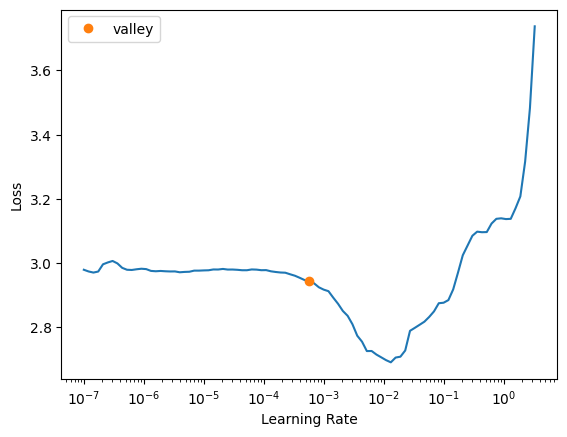

In [32]:
suggested_lrs = learn.lr_find()
lr = suggested_lrs.valley*3
f"Learning Rate: {lr}"

### Train the Model

In [33]:
learn.fine_tune(epochs=3, base_lr=lr, cbs=[MixedPrecision()])

### Save the Learner

In [34]:
learn.export(checkpoint_dir.absolute()/f"{model.name}.pkl")

### Save the Model Checkpoint

In [35]:
torch.save(learn.model.state_dict(), checkpoint_path)

## Making Predictions with the Model

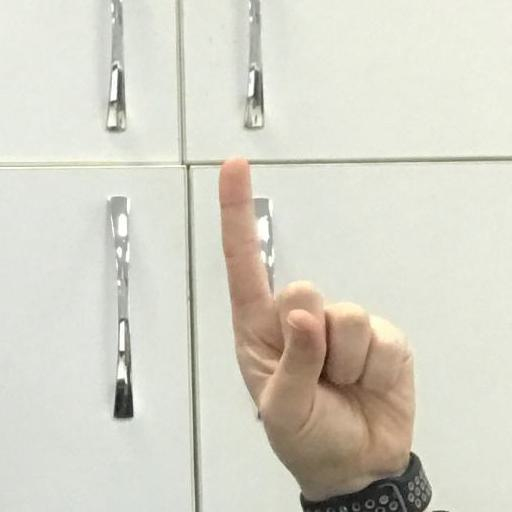

In [36]:
# Set the minimum input dimension for inference 
infer_sz = train_sz

# Choose a random item from the dataset
item_path = random.choice(dls.valid_ds.items)

label = item_path.parent.name

# Open the image and resize it
sample_img = Image.open(item_path)
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = dls.vocab[torch.argmax(pred_scores)]

# Display the image
display(sample_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target Class:": label,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
}).to_frame().style.hide(axis='columns')

### Testing the Model on New Data

The file ./pexels-elina-volkova-16191659.jpg already exists and overwrite is set to False.


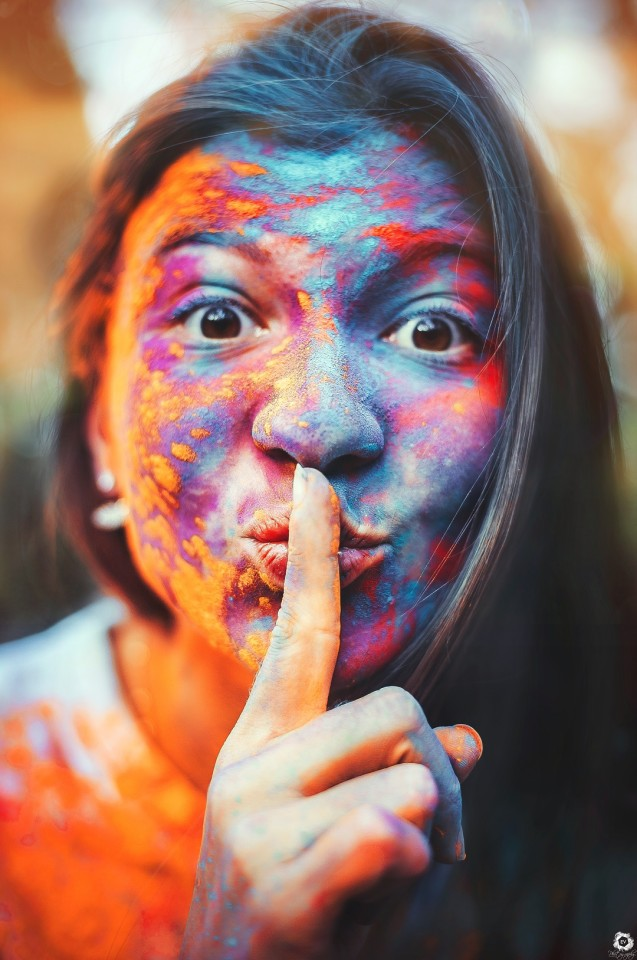

In [45]:
test_img_name = "pexels-elina-volkova-16191659.jpg"
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
test_img

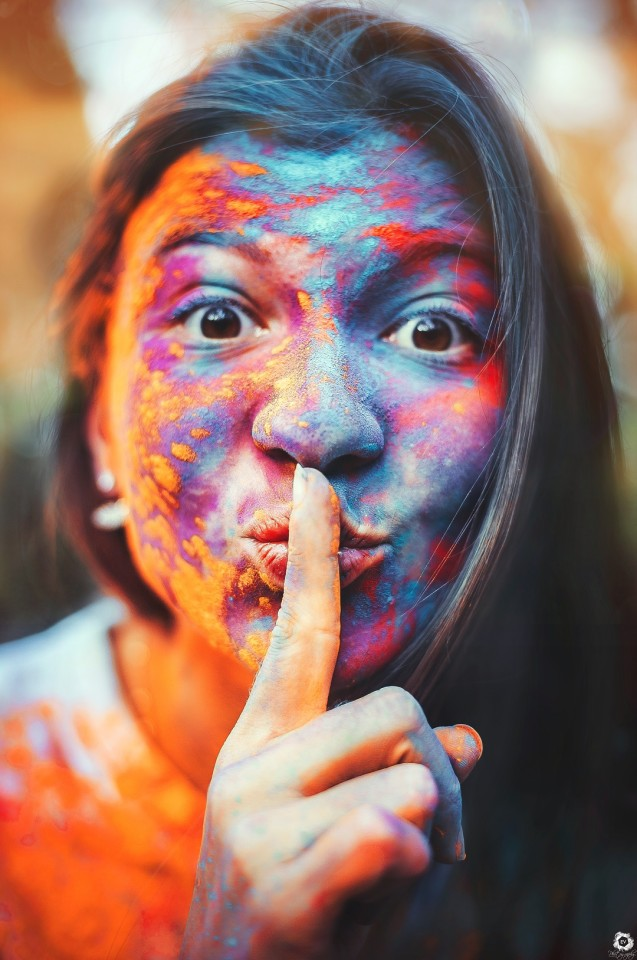

In [46]:
target_cls = "mute"

# Set the minimum input dimension for inference 
infer_sz = train_sz

inp_img = resize_img(test_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = learn.model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = dls.vocab[torch.argmax(pred_scores)]

# Display the image
display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Input Size:": inp_img.size,
    "Target Class:": target_cls,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
}).to_frame().style.hide(axis='columns')